In [ ]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [ ]:
#!pip install tensorboard

In [ ]:
# copy file in colab
##!cp '/content/drive/MyDrive/Data/Idea Data/wpod_net_org.h5' ./

!cp '/content/drive/MyDrive/yIdea-Dataset-(ALL bike Included).zip' ./
!cp '/content/drive/MyDrive/wpod-net-input_modified.json' ./
!unzip -q 'yIdea-Dataset-(ALL bike Included).zip' -d ./
!mkdir "data"
!mkdir 'sRMSprop-WPOD'

In [ ]:
model_dir = "/content/data"

In [ ]:
import os
#import glob
import random
import time
import json
import math
import shutil
from tqdm import tqdm
import PIL
from PIL import ImageDraw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from __future__ import print_function, division
from skimage import io, transform
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split

In [ ]:
PATH = './'
folder = "final-mixed"
json_file = 'final-mixed.json'
json_file2 = 'special.json'
height=120
width=480

test_size = 0.05

In [ ]:
#os.listdir(model_dir)

In [ ]:
with open(os.path.join(PATH, json_file), 'r') as f:
    label_data = json.load(f)

with open(os.path.join(PATH, json_file2), 'r') as f:
    label_data1 = json.load(f)

print("Total Number of train data point: {:,}".format(len(label_data)))
print("Total Number of test data point: {:,}".format(len(label_data1)))

Total Number of train data point: 8,900
Total Number of test data point: 118


In [ ]:
def resized_coords(coords, org_w, org_h, h=120, w=480):
    """
    function that returns the coordinates after reshaping the images
    """
    new = []
    for coord in coords:
        x, y = coord
        x = int(w*x/org_w)
        y = int(h*y/org_h)
        new.append([x,y])
    return new

In [ ]:
Names = []
Classes = []

for key, val in tqdm(label_data.items()):
    Names.append(key)
    if val.get('type') == 'colored':
        Classes.append(1)
    elif val.get('type') == 'gray':
        Classes.append(0)
    else:
        print(f"for file name `{key}`, unknown type")

100%|██████████| 8900/8900 [00:00<00:00, 1345006.33it/s]


In [ ]:
Classes.count(0), Classes.count(1)

(3044, 5856)

In [ ]:
train, val = train_test_split(Names, test_size = test_size, stratify = Classes, random_state = 42)
train_label, val_label, test_label = [], [], []


gtr, ctr = 0,0

for i in tqdm(train):
    coord = label_data[i]["coords"]
    org_w, org_h = label_data[i]["size"]["width"], label_data[i]["size"]["height"]
    coord = resized_coords(coord,org_w, org_h, height, width)
    train_label.append(coord)
   
    if Classes[Names.index(i)]==1:
        ctr += 1
    else:
        gtr += 1
        
print(f"\nIn train there are: {ctr}-colored and {gtr}-gray images. So % of gray is: {100*gtr/len(train)}%")

gtr, ctr = 0,0
for i in tqdm(val):
    coord = label_data[i]["coords"]
    org_w, org_h = label_data[i]["size"]["width"], label_data[i]["size"]["height"]
    coord = resized_coords(coord,org_w, org_h, height, width)
    val_label.append(coord)
    
    if Classes[Names.index(i)]==1:
        ctr += 1
    else:
        gtr += 1
        
print(f"\nIn validation there are: {ctr}-colored and {gtr}-gray images. So % of gray is: {100*gtr/len(val)}%")

for key in tqdm(label_data1.keys()):
    coord = label_data1[key]
    img = cv2.imread(os.path.join("./special-plates", key))
    org_h, org_w, _ = img.shape
    coord = resized_coords(coord,org_w, org_h, height, width)
    test_label.append(coord)

100%|██████████| 8455/8455 [00:00<00:00, 12085.07it/s]



In train there are: 5563-colored and 2892-gray images. So % of gray is: 34.20461265523359%


100%|██████████| 445/445 [00:00<00:00, 11040.32it/s]



In validation there are: 293-colored and 152-gray images. So % of gray is: 34.157303370786515%


100%|██████████| 118/118 [00:01<00:00, 88.67it/s]


In [ ]:
flatten_coords = lambda coords: [i[0] for i in coords] + [i[1] for i in coords]
reshape_coords = lambda coords: [[i,j] for i,j in zip(coords[:4], coords[4:])]

cols = ['coords-0-0', 'coords-1-0', 'coords-2-0', 'coords-3-0', 
        'coords-0-1', 'coords-1-1', 'coords-2-1', 'coords-3-1']

train_df = pd.DataFrame(columns = ["filename"])
train_df['filename']= train
train_df[cols]= np.array([flatten_coords(i) for i in train_label])

val_df = pd.DataFrame(columns = ["filename"])
val_df['filename']= val
val_df[cols]= np.array([flatten_coords(i) for i in val_label])

test_df = pd.DataFrame(columns = ["filename"])
test_df['filename']= list(label_data1.keys())
test_df[cols]= np.array([flatten_coords(i) for i in test_label])

assert len(train_df) == len(train)
assert len(val_df) == len(val)
assert len(test_df) == len(label_data1)

#coordinates = train_df.iloc[0, 1:]
#coordinates =  coordinates
#print(coordinates)

#train_df.to_csv('TRain.csv')
train_df.head()

,filename,coords-0-0,coords-1-0,coords-2-0,coords-3-0,coords-0-1,coords-1-1,coords-2-1,coords-3-1
0,69b98f9f3f547a57-0.png,43,436,415,43,2,14,110,103
1,19530-0.png,63,447,432,47,19,32,120,97
2,d7f1af9890d4f0b0-0.png,42,421,450,67,66,6,49,113
3,5dd346a3791a1054-0.png,15,469,469,15,16,50,116,76
4,1_uk_YY67SDZ_15856044.jpg,48,384,452,109,28,6,90,112


./final-mixed/1_uk_YY67SDZ_15856044.jpg
orginal shape:  (60, 70, 3)
current shape:  (120, 480, 3)
[[48, 28], [384, 6], [452, 90], [109, 112]]


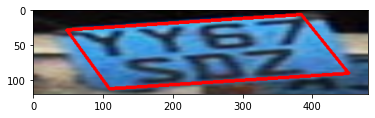

In [ ]:
index = 4
print(os.path.join(os.path.join(PATH, folder), train[index]))
img = cv2.imread(os.path.join(os.path.join(PATH, folder), train[index]))
print("orginal shape: ", img.shape)
img = cv2.resize(img, (width, height))
print("current shape: ", img.shape)

coords = train_label[index]
print(coords)
img = cv2.line(img, tuple(coords[0]), tuple(coords[1]), (0,0,255), 4)
img = cv2.line(img, tuple(coords[1]), tuple(coords[2]), (0,0,255), 4)
img = cv2.line(img, tuple(coords[2]), tuple(coords[3]), (0,0,255), 4)
img = cv2.line(img, tuple(coords[3]), tuple(coords[0]), (0,0,255), 4)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
class ResizeAndTensor(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.interpolation = PIL.Image.BICUBIC
        self.output_size = output_size
        self.toTensor = transforms.ToTensor()

    def __call__(self, imgx):
        """Convert ndarrays in sample to Tensors."""
        imgx = imgx.resize(self.output_size, self.interpolation)
        imgx = self.toTensor(imgx)
        return imgx

In [ ]:
class make_WPOD_dataset(Dataset):
    def __init__(self, df1, root_dir, transform): #, output_size):
        """
        Args:
            df1: input dataframe with filenames and coords
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.input_frame = df1
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.input_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir, self.input_frame.iloc[idx, 0])
        imgx = PIL.Image.open(img_name).convert('RGB')
        coordinates = self.input_frame.iloc[idx, 1:]
        coordinates = torch.FloatTensor(coordinates)
        if self.transform:
            imgx = self.transform(imgx)        
        sample = {'image': imgx, 'coordinates': coordinates}
        return sample

TRAIN DATASET
0 torch.Size([32, 3, 120, 480]) torch.Size([32, 8])
TRAIN DATASET
1 torch.Size([32, 3, 120, 480]) torch.Size([32, 8])
TRAIN DATASET
2 torch.Size([32, 3, 120, 480]) torch.Size([32, 8])
<class 'torch.Tensor'>
[ 52  50 453  12 450  67  41 105]


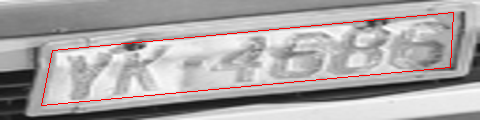

<class 'torch.Tensor'>
[ 50  11 439  17 436  94  48  90]


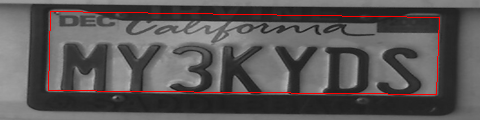

<class 'torch.Tensor'>
[ 63  20 391  11 429 108  56 108]


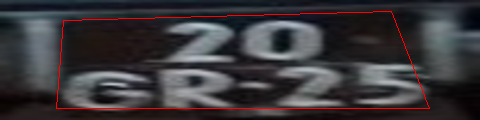

In [ ]:
colzzz = ['filename', 'coords-0-0', 'coords-0-1', 'coords-1-0',
                  'coords-1-1',  'coords-2-0', 'coords-2-1', 'coords-3-0', 
                  'coords-3-1']

batch_size = 32
train_df = train_df.reindex(columns=colzzz) # Rearrange collumns of DF
test_df = test_df.reindex(columns=colzzz)   # in format x1,y1, x2, y2, x3,y3, x4, y4
val_df = val_df.reindex(columns=colzzz)
train_dataset = make_WPOD_dataset(df1 = train_df,
                                           root_dir = os.path.join(PATH, folder),
                                 transform=transforms.Compose([
                                                ResizeAndTensor((width, height))
                                           ]))
test_dataset = make_WPOD_dataset(test_df,
                                           root_dir = os.path.join('/content/special-plates/'),
                                 transform=transforms.Compose([
                                                ResizeAndTensor((width, height))
                                           ]))
val_dataset = make_WPOD_dataset(val_df,
                                           root_dir = os.path.join(PATH, folder),
                                 transform=transforms.Compose([
                                                ResizeAndTensor((width, height))
                                 ]))

from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=4, pin_memory=True)

from IPython.display import Image as dispImage 

def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = sample_batched['image'], sample_batched['coordinates']
    #im_size = images_batch.size(2)
    #grid_border_size = 2
    #grid = utils.make_grid(images_batch)
    #plt.imshow(grid.numpy().transpose((1, 2, 0)))
    #plt.figure()
    #fig, axis = plt.subplots(1,3,figsize=(30,10))
    #print(images_batch)
    for i in range(3):
        pil_imgx = images_batch[i]
        print(type(pil_imgx))
        pil_imgx = transforms.ToPILImage()(pil_imgx.squeeze_(0))
        coords1 = landmarks_batch[i]
        coords1 = coords1.cpu().detach().numpy()
        coords1 = coords1.astype(int)
        print(coords1)
        draw = ImageDraw.Draw(pil_imgx)
        draw.line(tuple([coords1[0], coords1[1], coords1[2], coords1[3]]) , fill=(255, 0, 0))
        draw.line(tuple([coords1[2], coords1[3], coords1[4], coords1[5]]) , fill=(255, 0, 0))
        draw.line(tuple([coords1[4], coords1[5], coords1[6], coords1[7]]) , fill=(255, 0, 0))
        draw.line( tuple([coords1[6], coords1[7], coords1[0], coords1[1]]) , fill=(255, 0, 0))
        #draw.line((0, im.size[1], im.size[0], 0), fill=128)
        #axis[i].imshow(imgx)
        display(pil_imgx)

for i_batch, sample_batched in enumerate(train_dataloader):
    print('TRAIN DATASET')
    print(i_batch, sample_batched['image'].size(),
          sample_batched['coordinates'].size())

    # observe 2nd batch and stop.
    if i_batch == 2:
        #plt.figure()
        show_landmarks_batch(sample_batched)
        #plt.show()
        break

TEST DATASET
0 torch.Size([32, 3, 120, 480]) torch.Size([32, 8])
TEST DATASET
1 torch.Size([32, 3, 120, 480]) torch.Size([32, 8])
<class 'torch.Tensor'>
[ 42  46 448  15 473  68  63  98]


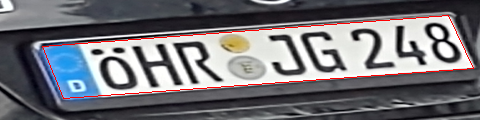

<class 'torch.Tensor'>
[  6  13 475   2 475 104   6 116]


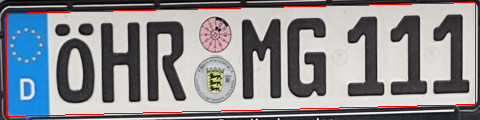

<class 'torch.Tensor'>
[ 40  42 445  18 468  77  56 102]


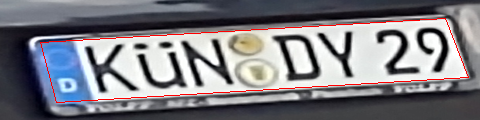

In [ ]:
# #from torch.utils.data import Dataset, DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=4, pin_memory=True)
# #print(test_dataloader)
# #print(list(dataloader2))

for i_batch, sample_batched in enumerate(test_dataloader):
    print('TEST DATASET')
    print(i_batch, sample_batched['image'].size(),
          sample_batched['coordinates'].size())

    # observe 1st batch and stop.
    if i_batch == 1:
        #plt.figure()
        show_landmarks_batch(sample_batched)
        #plt.show()
        break

VAL DATASET
0 torch.Size([32, 3, 120, 480]) torch.Size([32, 8])
VAL DATASET
1 torch.Size([32, 3, 120, 480]) torch.Size([32, 8])
VAL DATASET
2 torch.Size([32, 3, 120, 480]) torch.Size([32, 8])
<class 'torch.Tensor'>
[ 35  14 422  69 415 100  32  37]


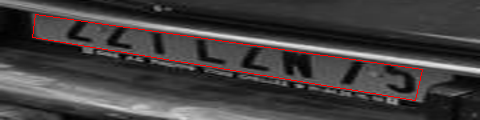

<class 'torch.Tensor'>
[ 36  18 416  61 404 118  18  62]


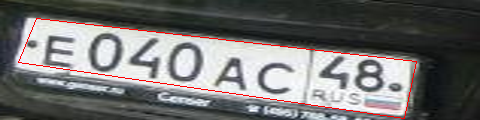

<class 'torch.Tensor'>
[ 48   6 432   8 436 107  43 103]


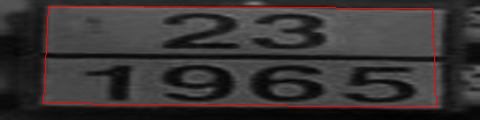

In [ ]:
val_dataloader = DataLoader(val_dataset, batch_size=batch_size,
                         shuffle=False, num_workers=4, pin_memory=True)

for i_batch, sample_batched in enumerate(val_dataloader):
    print('VAL DATASET')
    print(i_batch, sample_batched['image'].size(),
          sample_batched['coordinates'].size())

    # observe 2nd batch and stop.
    if i_batch == 2:
        #plt.figure()
        show_landmarks_batch(sample_batched)
        #plt.show()
        break


WPOD ARCHITECTURE - PyTorch


In [ ]:
from torch.utils.tensorboard import SummaryWriter

class wpod_net(nn.Module):
    def __init__(self):
        super(wpod_net, self).__init__()
        #self.Input_Layer = nn.Linear()
        self.conv2d_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=1, dilation=1, groups=1, bias=True, padding_mode= "replicate")
        self.batch_normalization_1 = nn.BatchNorm2d(num_features=16, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=1, dilation=1, groups=1, bias=True, padding_mode= "replicate")
        self.batch_normalization_2 = nn.BatchNorm2d(num_features=16, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.max_pooling2d_1= nn.MaxPool2d(kernel_size = (2, 2), stride=(2, 2), padding=0, dilation=1, return_indices=False, ceil_mode=False)
        self.conv2d_3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=1, dilation=1, groups=1, bias=True, padding_mode= "replicate")
        self.batch_normalization_3 = nn.BatchNorm2d(num_features=32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=1, dilation=1, groups=1, bias=True, padding_mode= "replicate")
        self.batch_normalization_4 = nn.BatchNorm2d(num_features=32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=1, dilation=1, groups=1, bias=True, padding_mode= "replicate")
        self.batch_normalization_5 = nn.BatchNorm2d(num_features=32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.max_pooling2d_2= nn.MaxPool2d(kernel_size = (2, 2), stride=(2, 2), padding=0, dilation=1, return_indices=False, ceil_mode=False)
        self.conv2d_6 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=1, dilation=1, groups=1, bias=True, padding_mode= "replicate")
        self.batch_normalization_6 = nn.BatchNorm2d(num_features=64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_7 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=1, dilation=1, groups=1, bias=True, padding_mode= "replicate")
        self.batch_normalization_7 = nn.BatchNorm2d(num_features=64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_8 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=1, dilation=1, groups=1, bias=True, padding_mode= "replicate")
        self.batch_normalization_8 = nn.BatchNorm2d(num_features=64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_9 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=1, dilation=1, groups=1, bias=True, padding_mode= "replicate")
        self.batch_normalization_9 = nn.BatchNorm2d(num_features=64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_10 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=1, dilation=1, groups=1, bias=True, padding_mode= "replicate")
        self.batch_normalization_10 = nn.BatchNorm2d(num_features=64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.max_pooling2d_3= nn.MaxPool2d(kernel_size = (2, 2), stride=(2, 2), padding=0, dilation=1, return_indices=False, ceil_mode=False)
        self.conv2d_11 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=1, dilation=1, groups=1, bias=True, padding_mode= "replicate")
        self.batch_normalization_11 = nn.BatchNorm2d(num_features=64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_12 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=1, dilation=1, groups=1, bias=True, padding_mode= "replicate")
        self.batch_normalization_12 = nn.BatchNorm2d(num_features=64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_13 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=1, dilation=1, groups=1, bias=True, padding_mode= "replicate")
        self.batch_normalization_13 = nn.BatchNorm2d(num_features=64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_14 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=1, dilation=1, groups=1, bias=True, padding_mode= "replicate")
        self.batch_normalization_14 = nn.BatchNorm2d(num_features=64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_15 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=1, dilation=1, groups=1, bias=True, padding_mode= "replicate")
        self.batch_normalization_15 = nn.BatchNorm2d(num_features=64, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.max_pooling2d_4= nn.MaxPool2d(kernel_size = (2, 2), stride=(2, 2), padding=0, dilation=1, return_indices=False, ceil_mode=False)
        self.conv2d_16 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=1, dilation=1, groups=1, bias=True, padding_mode= "replicate")
        self.batch_normalization_16 = nn.BatchNorm2d(num_features=128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_17 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=1, dilation=1, groups=1, bias=True, padding_mode= "replicate")
        self.batch_normalization_17 = nn.BatchNorm2d(num_features=128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_18 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=1, dilation=1, groups=1, bias=True, padding_mode= "replicate")
        self.batch_normalization_18 = nn.BatchNorm2d(num_features=128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_19 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=1, dilation=1, groups=1, bias=True, padding_mode= "replicate")
        self.batch_normalization_19 = nn.BatchNorm2d(num_features=128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_20 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=1, dilation=1, groups=1, bias=True, padding_mode= "replicate")
        self.batch_normalization_20 = nn.BatchNorm2d(num_features=128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_21 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=1, dilation=1, groups=1, bias=True, padding_mode= "replicate")
        self.batch_normalization_21 = nn.BatchNorm2d(num_features=128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_22 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=1, dilation=1, groups=1, bias=True, padding_mode= "replicate")
        self.batch_normalization_22 = nn.BatchNorm2d(num_features=128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_23 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=1, dilation=1, groups=1, bias=True, padding_mode= "replicate")
        self.batch_normalization_23 = nn.BatchNorm2d(num_features=128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_24 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=1, dilation=1, groups=1, bias=True, padding_mode= "replicate")
        self.batch_normalization_24 = nn.BatchNorm2d(num_features=128, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        self.conv2d_25 = nn.Conv2d(in_channels=128, out_channels=2, kernel_size=(3, 3), stride=(1, 1), padding=1, dilation=1, groups=1, bias=True, padding_mode= "replicate")
        self.conv2d_26 = nn.Conv2d(in_channels=128, out_channels=6, kernel_size=(3, 3), stride=(1, 1), padding=1, dilation=1, groups=1, bias=True, padding_mode= "replicate")
        self.flatten = nn.Flatten()
        self.output = nn.Linear(in_features=1680, out_features=8)
        
    def forward(self, x1):
        #x = self.Input_Layer(x)
        #y = torch.randn(1, 3, 120, 480)
        #x1 = self.Input_Layer(x1)
        x1 = F.relu(self.batch_normalization_1(self.conv2d_1(x1)))
        x1 = self.max_pooling2d_1(F.relu(self.batch_normalization_2(self.conv2d_2(x1))))
        x1 = F.relu(self.batch_normalization_3(self.conv2d_3(x1)))
        x2 = self.batch_normalization_5(self.conv2d_5(F.relu(self.batch_normalization_4(self.conv2d_4(x1)))))
        addition = x1 + x2 #torch.add(x1, x2)
        x1 = F.relu(self.batch_normalization_6(self.conv2d_6(self.max_pooling2d_2(F.relu(addition)))))
        x2 = self.batch_normalization_8(self.conv2d_8(F.relu(self.batch_normalization_7(self.conv2d_7(x1)))))
        x1 = F.relu(x1 + x2)
        x2 = self.batch_normalization_10(self.conv2d_10(F.relu(self.batch_normalization_9(self.conv2d_9(x1)))))
        addition = x1 + x2  #torch.add(x1, x2)
        x1 = F.relu(self.batch_normalization_11(self.conv2d_11(self.max_pooling2d_3(F.relu(addition)))))
        x2 = self.batch_normalization_13(self.conv2d_13(F.relu(self.batch_normalization_12(self.conv2d_12(x1)))))
        addition = x1 + x2 #torch.add(x1, x2)
        x1 = F.relu(addition)
        x2 = self.batch_normalization_15(self.conv2d_15(F.relu(self.batch_normalization_14(self.conv2d_14(x1)))))
        addition = x1 + x2 #torch.add(x1, x2)
        x1 = F.relu(self.batch_normalization_16(self.conv2d_16(self.max_pooling2d_4(F.relu(addition)))))
        x2 = self.batch_normalization_18(self.conv2d_18(F.relu(self.batch_normalization_17(self.conv2d_17(x1)))))
        addition = x1 + x2 #torch.add(x1, x2)
        x1 = F.relu(addition)
        x2 = self.batch_normalization_20(self.conv2d_20(F.relu(self.batch_normalization_19(self.conv2d_19(x1)))))
        addition = x1 + x2 #torch.add(x1, x2)
        x1 = F.relu(addition)
        x2 = self.batch_normalization_22(self.conv2d_22(F.relu(self.batch_normalization_21(self.conv2d_21(x1)))))
        addition = x1 + x2 #torch.add(x1, x2)
        x1 = F.relu(addition)
        x2 = self.batch_normalization_24(self.conv2d_24(F.relu(self.batch_normalization_23(self.conv2d_23(x1)))))
        addition = F.relu(x1 + x2)
        x1 = self.conv2d_25(addition)
        x2 = self.conv2d_26(addition)
        concatenate_1 = torch.cat((x1, x2), 1)
        x1 = self.flatten(concatenate_1)
        x1 = self.output(x1)
        return x1
        
#t1 = torch.zeros(1, 3, 120, 480, dtype=torch.float, requires_grad=True)
wpod_model = wpod_net()

#wpod_out = wpod_net()
#summary(wpod_model, (3, 120, 480))

In [ ]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

early_stopping = EarlyStopping(patience = 10, min_delta=0.25)

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = torch.nn.MSELoss(reduction='sum')
optimizer = optim.RMSprop(wpod_model.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, 
                          centered=False)
tfil = open('/content/sRMSprop-WPOD/training-WPOD-RMSprop-PyTorch.csv', 'w+')
vfil = open('/content/sRMSprop-WPOD/validation-WPOD-RMSprop-PyTorch.csv', 'w+')
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=45, gamma=0.5)


In [ ]:
def get_default_device():
    """Picking GPU if available or else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
print(device)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)

wpod_model = to_device(wpod_model, device)


cuda


In [ ]:
xdataloaders = {'train': train_dataloader,
                'val' : val_dataloader}
xdataset_sizes = {'train':len(train_dataloader),
                 'val': len(val_dataloader)}
import copy
import time

def get_lr(optimizer):
    '''Get Current Learning Rate'''
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    writer = SummaryWriter("/content/PyTorch_Summary/")
    best_acc = 0.0
    flag_early_stop = False
    for epoch in range(num_epochs):
        t1 = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 40)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                wpod_model.train()  # Set model to training mode
            else:
                wpod_model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for idx, xdata in enumerate(xdataloaders[phase], 0):
                inputs = xdata['image'].float().cuda() 
                labels = xdata['coordinates'].float().cuda()
                #inputs = inputs.to(device)
                #labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = wpod_model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                #running_corrects += torch.sum(outputs == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / xdataset_sizes[phase]
            #epoch_acc = running_corrects.double() / xdataset_sizes[phase]
            if phase == 'train':
                print('TRAIN PHASE: Loss: {:.4f}'.format(epoch_loss))
                tfil.writelines(str(epoch)+','+str(epoch_loss)+','+'\n')
                writer.add_scalar("Loss/train", epoch_loss, epoch)
            elif phase == 'val':
                print('VALIDATION PHASE: Loss: {:.4f}'.format(epoch_loss))
                early_stopping(epoch_loss)
                vfil.writelines(str(epoch)+','+str(epoch_loss)+','+'\n')
                writer.add_scalar("Loss/val", epoch_loss, epoch)
                if early_stopping.early_stop:
                    print('EARLY STOPPING')
                    flag_early_stop = True
                    break
            # deep copy the model
            # if phase == 'val' and epoch_acc > best_acc:
            #     best_acc = epoch_acc
            #     best_model_wts = copy.deepcopy(wpod_model.state_dict())
        t2 = time.time()
        print('EPOCH time taken =', t2 - t1, 'sec')
        print('Learning Rate', get_lr(optimizer))
        if flag_early_stop:
            print('*******EARLY STOPPING*******')
            break
        #fil1.writelines(str(epoch)+','+str(epoch_loss)+','+'\n')
        #writer.add_scalar("Loss/train", epoch_loss, epoch)
        #writer.add_scalar("Accuracy/train", epoch_acc, epoch)

    #print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    #wpod_model.load_state_dict(best_model_wts)
    print('Finished Training')
    writer.flush()
    return wpod_model

In [ ]:
model_ft = train_model(wpod_model, criterion, optimizer, step_lr_scheduler, num_epochs=140)
tfil.close()
vfil.close()
torch.save(model_ft, '/content/sRMSprop-WPOD/mWPOD_RMSProp.pth')
torch.save(model_ft.state_dict(), '/content/sRMSprop-WPOD/weights_WPOD_RMSProp.pth')
print('Saved model successfully')


Saved model successfully


In [ ]:
%cp '/content/sRMSprop-WPOD' -r '/content/drive/My Drive/sRMSprop-WPOD/'

ADAM Optimizer.

In [ ]:
!mkdir 'sADAMmse1-WPOD'

In [ ]:
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = optim.Adam(wpod_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
tfil = open('/content/sADAMmse1-WPOD/training-WPOD-ADAMmse-PyTorch.csv', 'w+')
vfil = open('/content/sADAMmse1-WPOD/validation-WPOD-ADAMmse-PyTorch.csv', 'w+')
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
early_stopping = EarlyStopping(patience = 10, min_delta=0.25)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer, step_lr_scheduler, num_epochs=140)
writer.flush()
tfil.close()
vfil.close()
torch.save(model_ft, '/content/sADAMmse1-WPOD/mWPOD_RMSProp.pth')
torch.save(model_ft.state_dict(), '/content/sADAMmse1-WPOD/weights_WPOD_RMSProp.pth')
print('Saved model successfully')

In [ ]:
%cp '/content/sADAMmse1-WPOD' -r '/content/drive/My Drive/sADAMmse1-WPOD/'

In [ ]:
!mkdir 'sADAMmae1-WPOD'

In [ ]:
criterion = nn.L1Loss()
optimizer = optim.Adam(wpod_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
tfil = open('/content/sADAMmse1-WPOD/training-WPOD-sADAMmae1-WPOD-PyTorch.csv', 'w+')
vfil = open('/content/sADAMmse1-WPOD/validation-WPOD-sADAMmae1-WPOD-PyTorch.csv', 'w+')
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
early_stopping = EarlyStopping(patience = 10, min_delta=0.001)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer, step_lr_scheduler, num_epochs=140)
writer.flush()
tfil.close()
vfil.close()
torch.save(model_ft, '/content/sADAMmae1-WPOD/mADAMmae1-WPOD.pth')
torch.save(model_ft.state_dict(), '/content/sADAMmae1-WPOD/weights_WPOD_sADAMmae1.pth')
print('Saved model successfully')

Fine Tunning full architecture with small learning rate

In [ ]:
#!mkdir 'sADAMmse-fine-WPOD'

In [ ]:
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = optim.Adam(wpod_model.parameters(), lr=1e-5, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
tfil = open('/content/sADAMmse-fine-WPOD/training-sADAMmse-fine-WPOD-PyTorch.csv', 'w+')
vfil = open('/content/sADAMmse-fine-WPOD/validation-sADAMmse-fine-WPOD-PyTorch.csv', 'w+')
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
early_stopping = EarlyStopping(patience = 10, min_delta=0.25)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer, step_lr_scheduler, num_epochs=500)
writer.flush()
tfil.close()
vfil.close()
torch.save(model_ft, '/content/sADAMmse-fine-WPOD/sADAMmse-fine-WPOD.pth')
torch.save(model_ft.state_dict(), '/content/sADAMmse-fine-WPOD/weights-sADAMmse-fine-WPOD.pt')
print('Saved model successfully')

In [ ]:
%cp '/content/sADAMmse-fine-WPOD' -r '/content/drive/My Drive/sADAMmse-fine-WPOD/'

In [ ]:
!mkdir 'sADAMmae-fine-WPOD'

In [ ]:
criterion = nn.L1Loss()
optimizer = optim.Adam(wpod_model.parameters(), lr=1e-5, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
tfil = open('/content/sADAMmae-fine-WPOD/training-sADAMmae-fine-WPOD-PyTorch.csv', 'w+')
vfil = open('/content/sADAMmae-fine-WPOD/validation-sADAMmae-fine-WPOD-PyTorch.csv', 'w+')
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)
early_stopping = EarlyStopping(patience = 10, min_delta=0.001)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer, step_lr_scheduler, num_epochs=500)
writer.flush()
tfil.close()
vfil.close()
torch.save(model_ft, '/content/sADAMmae-fine-WPOD/sADAMmae2-fine-WPOD.pth')
torch.save(model_ft.state_dict(), '/content/sADAMmae-fine-WPOD/weights-sADAMmae2-fine-WPOD.pt')
print('Saved model successfully')

In [ ]:
%cp '/content/sADAMmae-fine-WPOD' -r '/content/drive/My Drive/sADAMmae2-fine-WPOD/'

In [ ]:
%cp '/content/sADAMmae1-WPOD' -r '/content/drive/My Drive/sADAMmae1-WPOD/'
%cp '/content/PyTorch_Summary' -r '/content/drive/My Drive/anpr-PyTorch_Summary/'
%cp '/content/special-plates' -r '/content/drive/My Drive/anpr-special-plates/'


In [ ]:
names = train_df[train_df['filename'].apply(lambda x: x.startswith('0_') or x.startswith("1_") or  x.startswith("gray_"))]['filename'].tolist()

TESTING
0 torch.Size([32, 3, 120, 480])
<class 'torch.Tensor'>


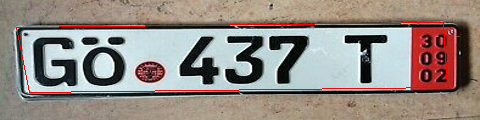

<class 'torch.Tensor'>


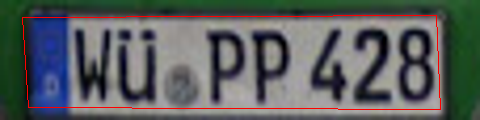

<class 'torch.Tensor'>


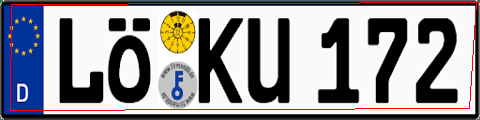

<class 'torch.Tensor'>


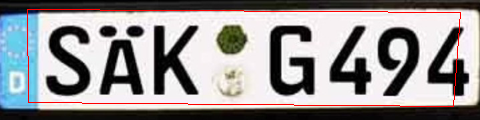

<class 'torch.Tensor'>


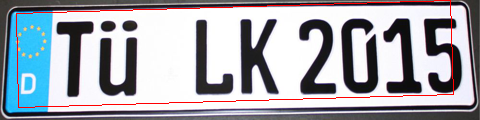

<class 'torch.Tensor'>


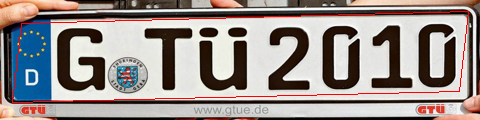

<class 'torch.Tensor'>


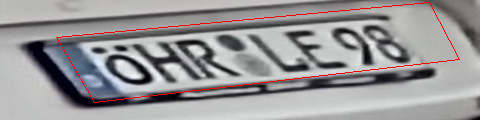

<class 'torch.Tensor'>


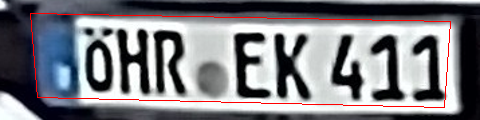

<class 'torch.Tensor'>


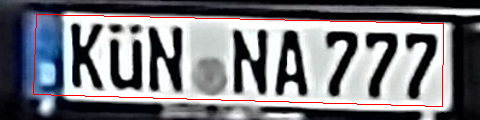

<class 'torch.Tensor'>


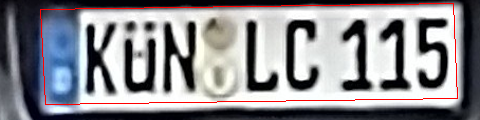

<class 'torch.Tensor'>


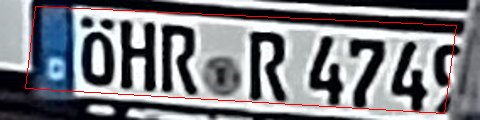

<class 'torch.Tensor'>


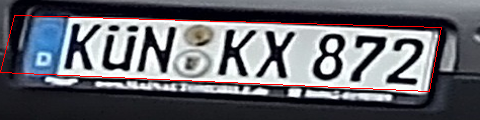

<class 'torch.Tensor'>


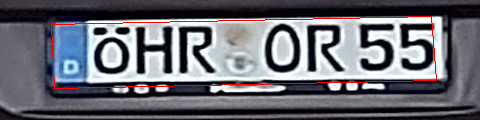

<class 'torch.Tensor'>


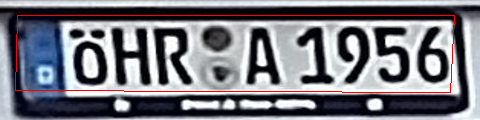

<class 'torch.Tensor'>


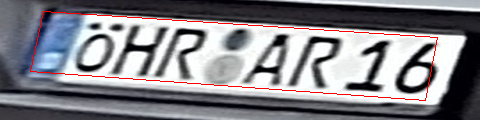

<class 'torch.Tensor'>


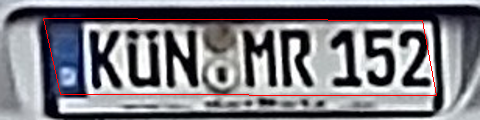

<class 'torch.Tensor'>


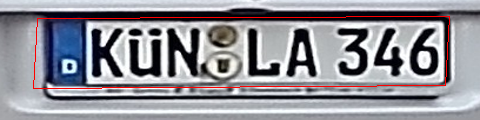

<class 'torch.Tensor'>


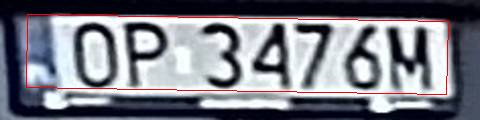

<class 'torch.Tensor'>


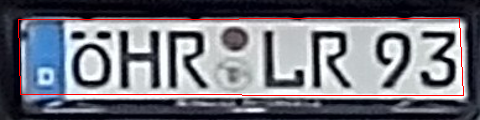

<class 'torch.Tensor'>


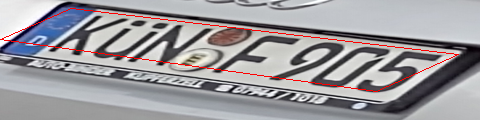

<class 'torch.Tensor'>


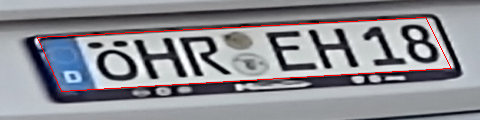

<class 'torch.Tensor'>


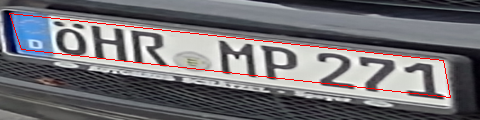

<class 'torch.Tensor'>


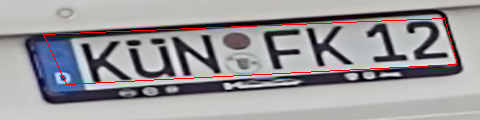

<class 'torch.Tensor'>


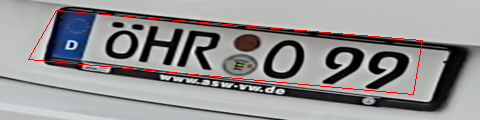

<class 'torch.Tensor'>


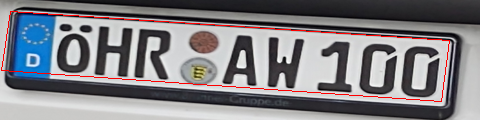

<class 'torch.Tensor'>


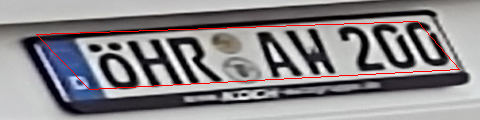

<class 'torch.Tensor'>


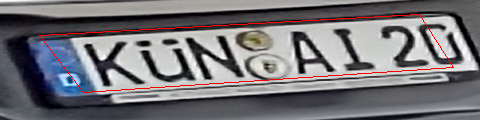

<class 'torch.Tensor'>


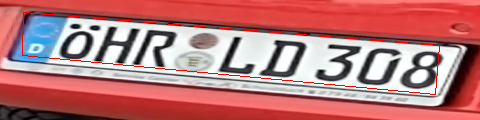

<class 'torch.Tensor'>


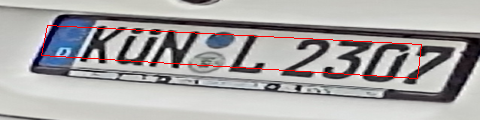

<class 'torch.Tensor'>


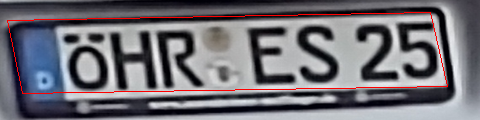

<class 'torch.Tensor'>


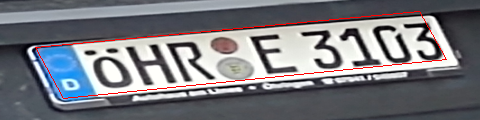

<class 'torch.Tensor'>


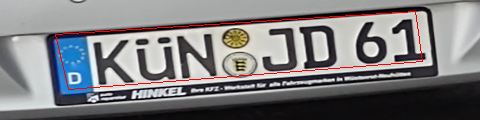

Done


In [ ]:
for i_batch, sample_batched in enumerate(test_dataloader):
    print('TESTING')
    print(i_batch, sample_batched['image'].size()) #, sample_batched['coordinates'].size())
    images_batch = sample_batched['image']
    batch_coords = model_ft(images_batch.float().cuda())
    for i_b in range(batch_size):
        imgx = images_batch[i_b]
        print(type(imgx))
        imgx = transforms.ToPILImage()(imgx.squeeze_(0))
        coords1 = batch_coords[i_b]
        draw = ImageDraw.Draw(imgx)
        draw.line(tuple([coords1[0], coords1[1], coords1[2], coords1[3]]) , fill=(255, 0, 0))
        draw.line(tuple([coords1[2], coords1[3], coords1[4], coords1[5]]) , fill=(255, 0, 0))
        draw.line(tuple([coords1[4], coords1[5], coords1[6], coords1[7]]) , fill=(255, 0, 0))
        draw.line( tuple([coords1[6], coords1[7], coords1[0], coords1[1]]) , fill=(255, 0, 0))
        display(imgx)
        #imgx.save(os.path.join(r'Y:\Jan-FL\premium-anpr\data\wpod-torch', str(i_b) + '.png'), 'PNG')
    break
print('Done')